**Magnification Dependent Binary Classification of BreakHis using Sigmoid as activation function**

In [ ]:
from google.colab import drive         # Mounting Colab to drive
drive.mount('/content/drive')

In [ ]:
#Importing all the Necessary Libraries
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
from sklearn import metrics
import itertools


%matplotlib inline

Data Loading Function

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png" or ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

Loading images from each path by going into the directories and making them a numpy array.

Loading Benign images in a Numpy array

In [ ]:
types = os.listdir('/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB')
print(types)
px = '/40X'                 # Give the necessary Magnification   (40X, 100X, 200X, 400X)
for i in range(len(types)):
  cases_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/'+types[i]
  print(cases_path)
  cases = os.listdir(cases_path)
  print(cases)
  for j in range(len(cases)):
    path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/'+types[i]+'/'+cases[j]+px
    print(path)
    if j==0:
      benign = np.array(Dataset_loader(path, 128))     # Give the pixel count according to the Network being used.
    else:
      x = np.array(Dataset_loader(path, 128))
      benign = np.concatenate((benign,x),axis=0)
    print(len(benign))
  if i==0:
    benign_all = benign
  else:
    benign_all = np.concatenate((benign_all,benign),axis=0)
print(len(benign_all))

['fibroadenoma', 'tubular_adenoma', 'adenosis', 'phyllodes_tumor']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma
['SOB_B_F_14-25197', 'SOB_B_F_14-23222AB', 'SOB_B_F_14-29960AB', 'SOB_B_F_14-9133', 'SOB_B_F_14-23060AB', 'SOB_B_F_14-23060CD', 'SOB_B_F_14-21998CD', 'SOB_B_F_14-21998EF', 'SOB_B_F_14-14134E', 'SOB_B_F_14-14134']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X


100%|██████████| 22/22 [00:05<00:00,  3.94it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X


100%|██████████| 17/17 [00:04<00:00,  4.23it/s]


39
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X


100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


57
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


83
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X


100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


106
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X


100%|██████████| 14/14 [00:03<00:00,  3.93it/s]


120
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X


100%|██████████| 37/37 [00:08<00:00,  4.61it/s]


157
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X


100%|██████████| 31/31 [00:07<00:00,  4.24it/s]


188
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X


100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


217
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


253
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma
['SOB_B_TA_14-19854C', 'SOB_B_TA_14-21978AB', 'SOB_B_TA_14-16184CD', 'SOB_B_TA_14-3411F', 'SOB_B_TA_14-16184', 'SOB_B_TA_14-15275', 'SOB_B_TA_14-13200']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X


100%|██████████| 16/16 [00:03<00:00,  5.01it/s]


16
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X


100%|██████████| 16/16 [00:03<00:00,  4.49it/s]


32
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X


100%|██████████| 35/35 [00:08<00:00,  4.17it/s]


67
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X


100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


83
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X


100%|██████████| 39/39 [00:10<00:00,  3.80it/s]


122
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


134
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


149
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis
['SOB_B_A_14-22549CD', 'SOB_B_A_14-29960CD', 'SOB_B_A_14-22549AB', 'SOB_B_A_14-22549G']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


35
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


50
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X


100%|██████████| 29/29 [00:06<00:00,  4.55it/s]


79
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X


100%|██████████| 35/35 [00:07<00:00,  4.52it/s]


114
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor
['SOB_B_PT_14-29315EF', 'SOB_B_PT_14-21998AB', 'SOB_B_PT_14-22704']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X


100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


13
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X


100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


71
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X


100%|██████████| 38/38 [00:08<00:00,  4.68it/s]


109
625


Loading Malignant images in a Numpy array

In [ ]:
types = os.listdir('/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB')
print(types)
px = '/40X'                 # Give the necessary Magnification   (40X, 100X, 200X, 400X)
for i in range(len(types)):
  cases_path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/'+types[i]
  print(cases_path)
  cases = os.listdir(cases_path)
  print(cases)
  for j in range(len(cases)):
    path = '/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/'+types[i]+'/'+cases[j]+px
    print(path)
    if j==0:
      malignant = np.array(Dataset_loader(path, 128))
    else:
      x = np.array(Dataset_loader(path, 128))
      malignant = np.concatenate((malignant,x),axis=0)
    print(len(malignant))
  if i==0:
    malignant_all = malignant
  else:
    malignant_all = np.concatenate((malignant_all,malignant),axis=0)
print(len(malignant_all))

['papillary_carcinoma', 'mucinous_carcinoma', 'ductal_carcinoma', 'lobular_carcinoma']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma
['SOB_M_PC_15-190EF', 'SOB_M_PC_14-9146', 'SOB_M_PC_14-15704', 'SOB_M_PC_14-12465', 'SOB_M_PC_14-19440', 'SOB_M_PC_14-15687B']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X


100%|██████████| 19/19 [00:04<00:00,  4.29it/s]


19
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X


100%|██████████| 23/23 [00:05<00:00,  4.44it/s]


42
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X


100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


72
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-12465/40X


100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


93
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X


100%|██████████| 35/35 [00:08<00:00,  4.05it/s]


128
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


145
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma
['SOB_M_MC_14-19979C', 'SOB_M_MC_14-19979', 'SOB_M_MC_14-18842D', 'SOB_M_MC_14-18842', 'SOB_M_MC_14-16456', 'SOB_M_MC_14-13418DE', 'SOB_M_MC_14-13413', 'SOB_M_MC_14-12773', 'SOB_M_MC_14-10147']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X


100%|██████████| 17/17 [00:04<00:00,  4.08it/s]


17
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X


100%|██████████| 26/26 [00:05<00:00,  4.64it/s]


43
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X


100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


59
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


74
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X


100%|██████████| 46/46 [00:10<00:00,  4.46it/s]


120
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


135
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X


100%|██████████| 29/29 [00:06<00:00,  4.57it/s]


164
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


190
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


205
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma
['SOB_M_DC_14-8168', 'SOB_M_DC_14-9461', 'SOB_M_DC_14-5695', 'SOB_M_DC_14-6241', 'SOB_M_DC_14-5287', 'SOB_M_DC_14-5694', 'SOB_M_DC_14-4364', 'SOB_M_DC_14-2773', 'SOB_M_DC_14-4372', 'SOB_M_DC_14-3909', 'SOB_M_DC_14-2985', 'SOB_M_DC_14-2980', 'SOB_M_DC_14-2523', 'SOB_M_DC_14-20636', 'SOB_M_DC_14-18650', 'SOB_M_DC_14-20629', 'SOB_M_DC_14-17915', 'SOB_M_DC_14-17901', 'SOB_M_DC_14-16875', 'SOB_M_DC_14-16601', 'SOB_M_DC_14-16716', 'SOB_M_DC_14-17614', 'SOB_M_DC_14-16448', 'SOB_M_DC_14-16336', 'SOB_M_DC_14-15792', 'SOB_M_DC_14-16188', 'SOB_M_DC_14-14946', 'SOB_M_DC_14-13993', 'SOB_M_DC_14-15572', 'SOB_M_DC_14-14926', 'SOB_M_DC_14-15696', 'SOB_M_DC_14-14015', 'SOB_M_DC_14-12312', 'SOB_M_DC_14-13412', 'SOB_M_DC_14-11951', 'SOB_M_DC_14-11520', 'SOB_M_DC_14-10926', 'SOB_M_DC_14-11031']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


10
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X


100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


36
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X


100%|██████████| 23/23 [00:05<00:00,  4.34it/s]


59
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X


100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


91
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X


100%|██████████| 23/23 [00:05<00:00,  3.87it/s]


114
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


136
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/40X


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


137
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


167
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X


100%|██████████| 21/21 [00:04<00:00,  4.22it/s]


188
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X


100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


214
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


234
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


254
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/40X


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


264
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


289
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X


100%|██████████| 29/29 [00:07<00:00,  3.71it/s]


318
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


354
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


380
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X


100%|██████████| 26/26 [00:05<00:00,  4.42it/s]


406
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X


100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


420
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/40X


100%|██████████| 12/12 [00:02<00:00,  4.20it/s]


432
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X


100%|██████████| 38/38 [00:09<00:00,  4.06it/s]


470
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X


100%|██████████| 39/39 [00:09<00:00,  3.99it/s]


509
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X


100%|██████████| 11/11 [00:02<00:00,  4.56it/s]


520
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


533
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X


100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


547
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X


100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


571
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


602
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X


100%|██████████| 37/37 [00:09<00:00,  4.06it/s]


639
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X


100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


662
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


682
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X


100%|██████████| 23/23 [00:05<00:00,  3.99it/s]


705
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X


100%|██████████| 18/18 [00:04<00:00,  4.33it/s]


723
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X


100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


755
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13412/40X


100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


787
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X


100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


814
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


839
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X


100%|██████████| 11/11 [00:02<00:00,  4.10it/s]


850
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X


100%|██████████| 14/14 [00:03<00:00,  3.93it/s]


864
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma
['SOB_M_LC_14-16196', 'SOB_M_LC_14-15570C', 'SOB_M_LC_14-12204', 'SOB_M_LC_14-15570', 'SOB_M_LC_14-13412']
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X


100%|██████████| 22/22 [00:05<00:00,  4.27it/s]


22
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X


100%|██████████| 31/31 [00:07<00:00,  4.00it/s]


53
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


73
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X


100%|██████████| 51/51 [00:11<00:00,  4.41it/s]


124
/content/drive/MyDrive/Datasets/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-13412/40X


100%|██████████| 32/32 [00:07<00:00,  4.33it/s]

156
1370


In [ ]:
print(len(benign_all), len(malignant_all))

625 1370


In [ ]:
benign_label = np.zeros(len(benign_all))        # Labelling Benign as '0' and Malignant as '1'
malignant_label = np.ones(len(malignant_all))

In [ ]:
x = np.concatenate((benign_all,malignant_all) ,axis=0) # concatenating the benign and malignant image arrays 
x=x/255     #Normalization
y = np.concatenate((benign_label,malignant_label) ,axis=0) # concatenating the benign and malignant label arrays

In [ ]:
print(len(x))

1995


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)   #Splitting the data as 70% in Train Set and 30% in Test Set.

In [ ]:
s=np.arange(x_train.shape[0])            #Shuffling the data
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]

y_train=to_categorical(y_train, num_classes=2)         # One hot encoding
y_test=to_categorical(y_test, num_classes=2)


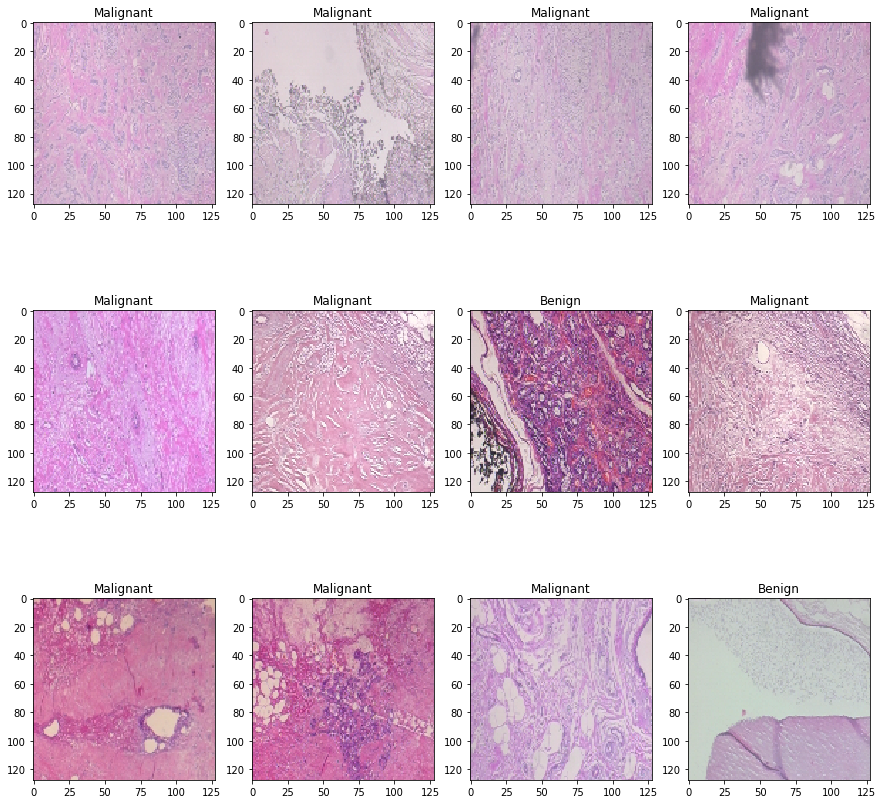

In [ ]:
fig=plt.figure(figsize=(15, 15))              #Displaying some images
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')    
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 16               # Batch Size

train_generator = ImageDataGenerator(            #Data Augmentation
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,  
    )

In [ ]:
def build_model():             # Creating the Model
    model = Sequential()
    model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(128,128,3)))       #Give the input shape according to the Network to be used.
                                                                                                #Change the name of the network accordingly.
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())

    
    model.add(layers.Dense(2,activation = "sigmoid"))
    
    
    model.compile(
        loss= "binary_crossentropy",
        optimizer="adam",
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()          # Building the model
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/content/drive/MyDrive/Project/Binary Classification/Magnification Dependent/40X/Sigmoid/DenseNet/densenet_sigmoid.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
#Training the Model
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,                   
    callbacks=[learn_control, checkpoint]
)

Epoch 1/100
87/87 [==============================] - 89s 356ms/step - loss: 0.5532 - accuracy: 0.7701

Epoch 00001: accuracy improved from -inf to 0.77006, saving model to /content/drive/MyDrive/Project/Binary Classification/Magnification Dependent/40X/Sigmoid/DenseNet/densenet_sigmoid.h5
Epoch 2/100
87/87 [==============================] - 27s 313ms/step - loss: 0.5109 - accuracy: 0.7865

Epoch 00002: accuracy improved from 0.77006 to 0.78653, saving model to /content/drive/MyDrive/Project/Binary Classification/Magnification Dependent/40X/Sigmoid/DenseNet/densenet_sigmoid.h5
Epoch 3/100
87/87 [==============================] - 27s 312ms/step - loss: 0.4553 - accuracy: 0.8080

Epoch 00003: accuracy improved from 0.78653 to 0.80802, saving model to /content/drive/MyDrive/Project/Binary Classification/Magnification Dependent/40X/Sigmoid/DenseNet/densenet_sigmoid.h5
Epoch 4/100
87/87 [==============================] - 27s 312ms/step - loss: 0.4354 - accuracy: 0.8259

Epoch 00004: accuracy

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'lr'])

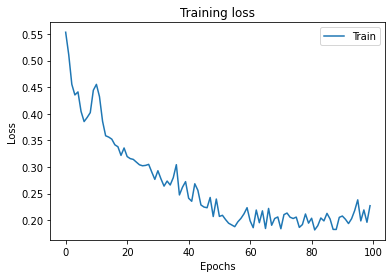

In [ ]:
plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'],loc='upper right')
plt.show()

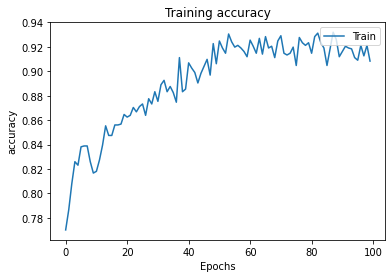

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Train'],loc='upper right')
plt.show()

In [ ]:
# making predictions using the trained model
Y_pred = model.predict(x_test)

In [ ]:
# Obtaining accuracy Score
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

0.9599332220367279

Confusion matrix, without normalization
[[174  11]
 [ 13 401]]


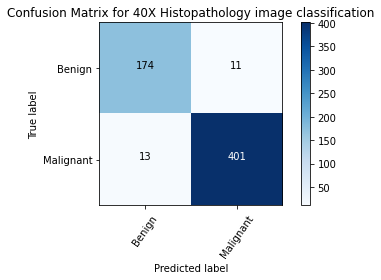

In [ ]:
`# Plotting confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign','Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for 40X Histopathology image classification')

In [ ]:
# Generating classification report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(Y_pred,axis=1), target_names=cm_plot_label))

              precision    recall  f1-score   support

      Benign       0.93      0.94      0.94       185
   Malignant       0.97      0.97      0.97       414

    accuracy                           0.96       599
   macro avg       0.95      0.95      0.95       599
weighted avg       0.96      0.96      0.96       599



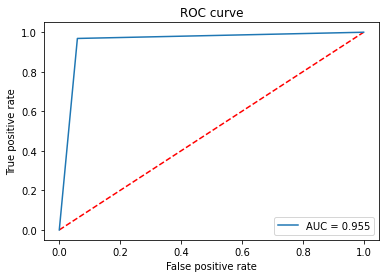

In [ ]:
#Plotting the ROc Curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()